In [120]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [131]:
# Constants
N=3 # Three Oscillators
ar=20 # rad/s
ax=3 # rad/s
wn = np.array([[1], [1], [1]]) # natural frequency: "speed"|

# Coupling Weights (in 1/s=Hz)
w = np.matrix([[0,   0.5, 0.5],
               [0.5, 0, 0.5],
               [0.5, 0.5, 0]])

# Phase Bias (in rad)\
PI = math.pi
phi_fwd = np.matrix([[0    , 0, 0],
                     [PI/2 , 0, 0],
                     [-PI/2, 0, 0]])
phi_bwd = np.matrix([[0    , 0, 0],
                     [-PI/2 , 0, 0],
                     [PI/2, 0, 0]])
phi_rtr = np.matrix([[0    , 0, 0],
                     [PI/2 , 0, 0],
                     [PI/2, 0, 0]])
phi_rtl = np.matrix([[0    , 0, 0],
                     [-PI/2 , 0, 0],
                     [-PI/2, 0, 0]])
phi = np.matrix([[0    , 0, 0],
                 [0 , 0, 0],
                 [0, 0, 0]])

# Target Values
R = np.array([[12.0], [40.0], [40.0]])     # Amplitude
X = np.array([[0.0], [0.0], [0.0]])    # Offset

X_fwd = np.array([[0.0], [PI/2], [-PI/2]])    # Offset
X_cwr = np.array([[0.0], [PI/2], [PI/2]])    # Offset
X_ccwr = np.array([[0.0], [-PI/2], [-PI/2]])    # Offset
X = X_fwd * 180


# State Variables
Phi = np.array([[0.0], [0.0], [0.0]])  # Phase
r = np.array([[0.0], [0.0], [0.0]])   # Amplitude
r_d = np.array([[0.0], [0.0], [0.0]])   # Amplit|ude_D
x = np.array([[0.0], [0.0], [0.0]])   # Offset
x_d = np.array([[0.0], [0.0], [0.0]])   # Offset_D

In [132]:
# 1-ODE  for Phi
def f_Phi(Phi, wn, w, phi):
    Phi_j = np.kron(np.transpose(Phi), np.ones((3,1)))
    Phi_i = np.kron(Phi, np.ones((1,3)))
    alpha = np.sin(Phi_j - Phi_i - phi)
    return wn + np.multiply(w,alpha) * r

# 2-ODE for r
def f_r(r, rd, ar, R):
    return ar * ( (ar/4) * (R-r) - rd)

# 2-ODE for x
def f_x(x, xd, ax, X):
    return ax * ( (ax/4) * (X-x) - xd)

def f_theta(x, r, Phi):
    return np.transpose(np.asarray(r) * np.sin(np.asarray(Phi) + np.asarray(x)))

In [133]:
def update(wn, w, phi, Phi, r, r_d, x, x_d, ar, ax, h=0.01):
    Phi_d = f_Phi(Phi, wn, w, phi)
    new_Phi = Phi + h * Phi_d
    
    r_dd = f_r(r, r_d, ar, R)
    new_r_d = r_d + h * r_dd
    new_r = r + h * r_d
    
    x_dd = f_x(x, x_d, ax, X)
    new_x_d = x_d + h * x_dd
    new_x = x + h * x_d
    
    Phi = new_Phi
    r = new_r
    r_d = new_r_d
    x = new_x
    x_d = new_x_d
    
    return (Phi, r, r_d, x, x_d)
    

In [134]:
theta = None
Phi_plot = None
phase_plot = None
r_plot = None
x_plot = None

# Starts With Forwards
gait_switch = [( 0, X_fwd,"Forward"),
               (20, X_cwr, "CWR"),
               (40, X_fwd, 'Forward'),
               (60, X_ccwr, "CCWR"),
               (80, X_cwr, 'CWR')]
gait_o = gait_switch

sim_time = 100 # seconds
h = 0.01 # euler step length in seconds
for idx, step in enumerate(range(0,int(sim_time/h))):
    if len(gait_switch) and step*h > gait_switch[0][0]:
        X = gait_switch[0][1]
        gait_switch = gait_switch[1:]
    wn =  np.array([[1 + 5 * idx/6000], 
                    [1 + 5 * idx/6000], 
                    [1 + 5 * idx/6000]])
    
    
    Phi, r, r_d, x, x_d = update(wn, w, phi, Phi, r, r_d, x, x_d, ar, ax, h)
    if theta is None:
        theta = f_theta(x,r,Phi)
        Phi_plot = np.transpose(Phi)
        phase_plot = None
        r_plot = r
        x_plot = x
    else:
        theta = np.vstack((theta, f_theta(x,r,Phi)))
        r_plot = np.hstack((r_plot, r))
        x_plot = np.hstack((x_plot, x))
        Phi_plot = np.vstack((Phi_plot, np.transpose(Phi)))
        
x_plot = np.transpose(x_plot)
r_plot = np.transpose(r_plot)


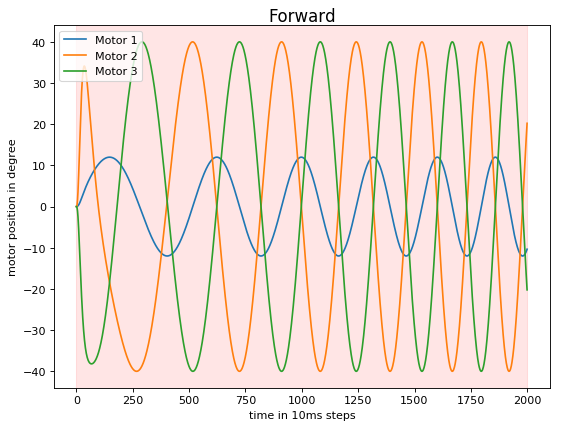

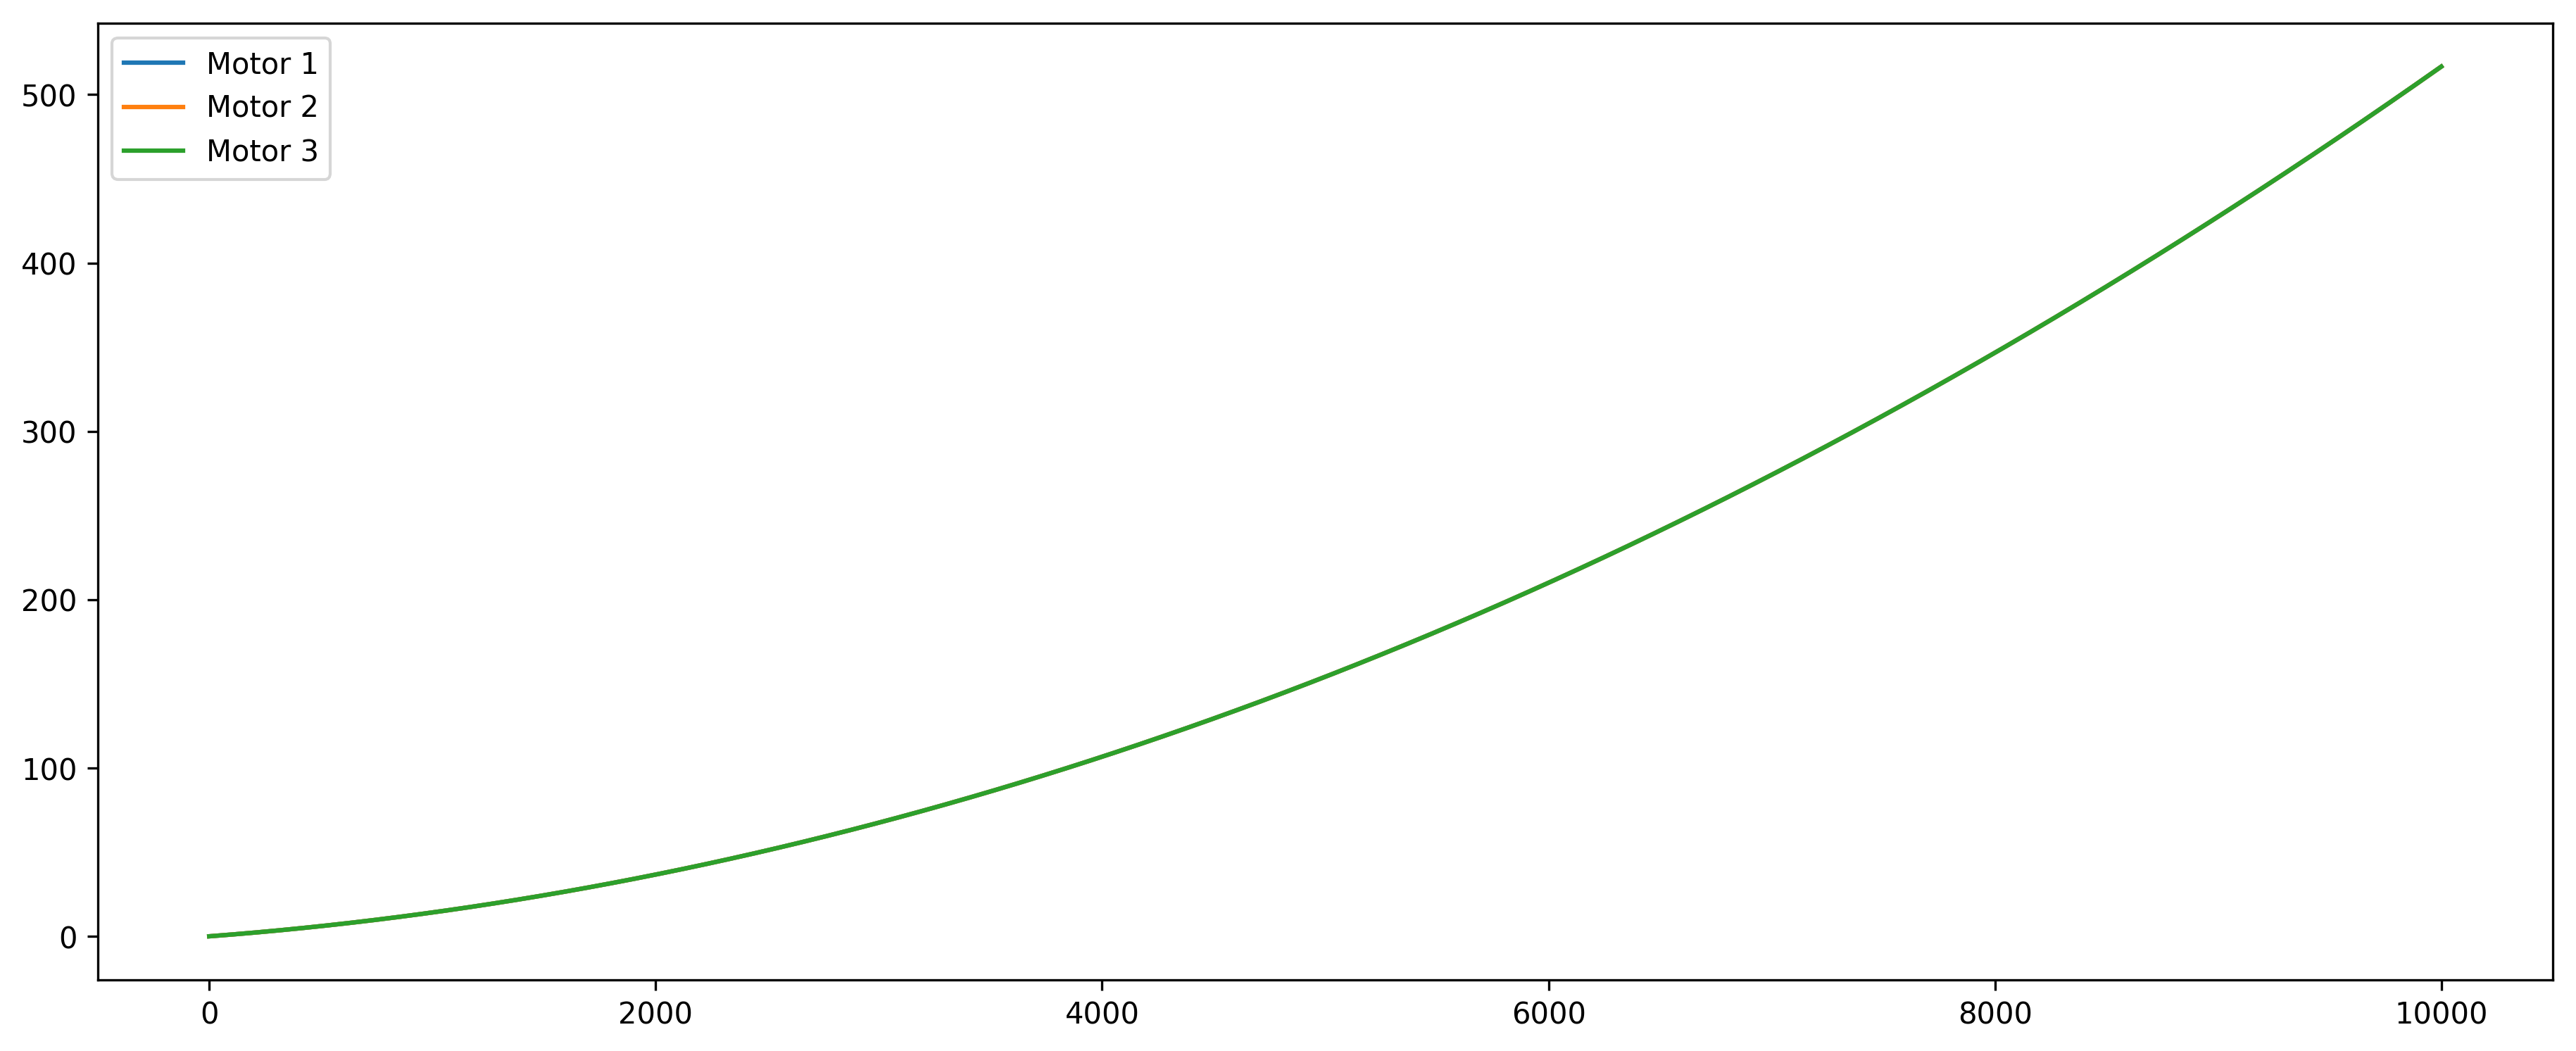

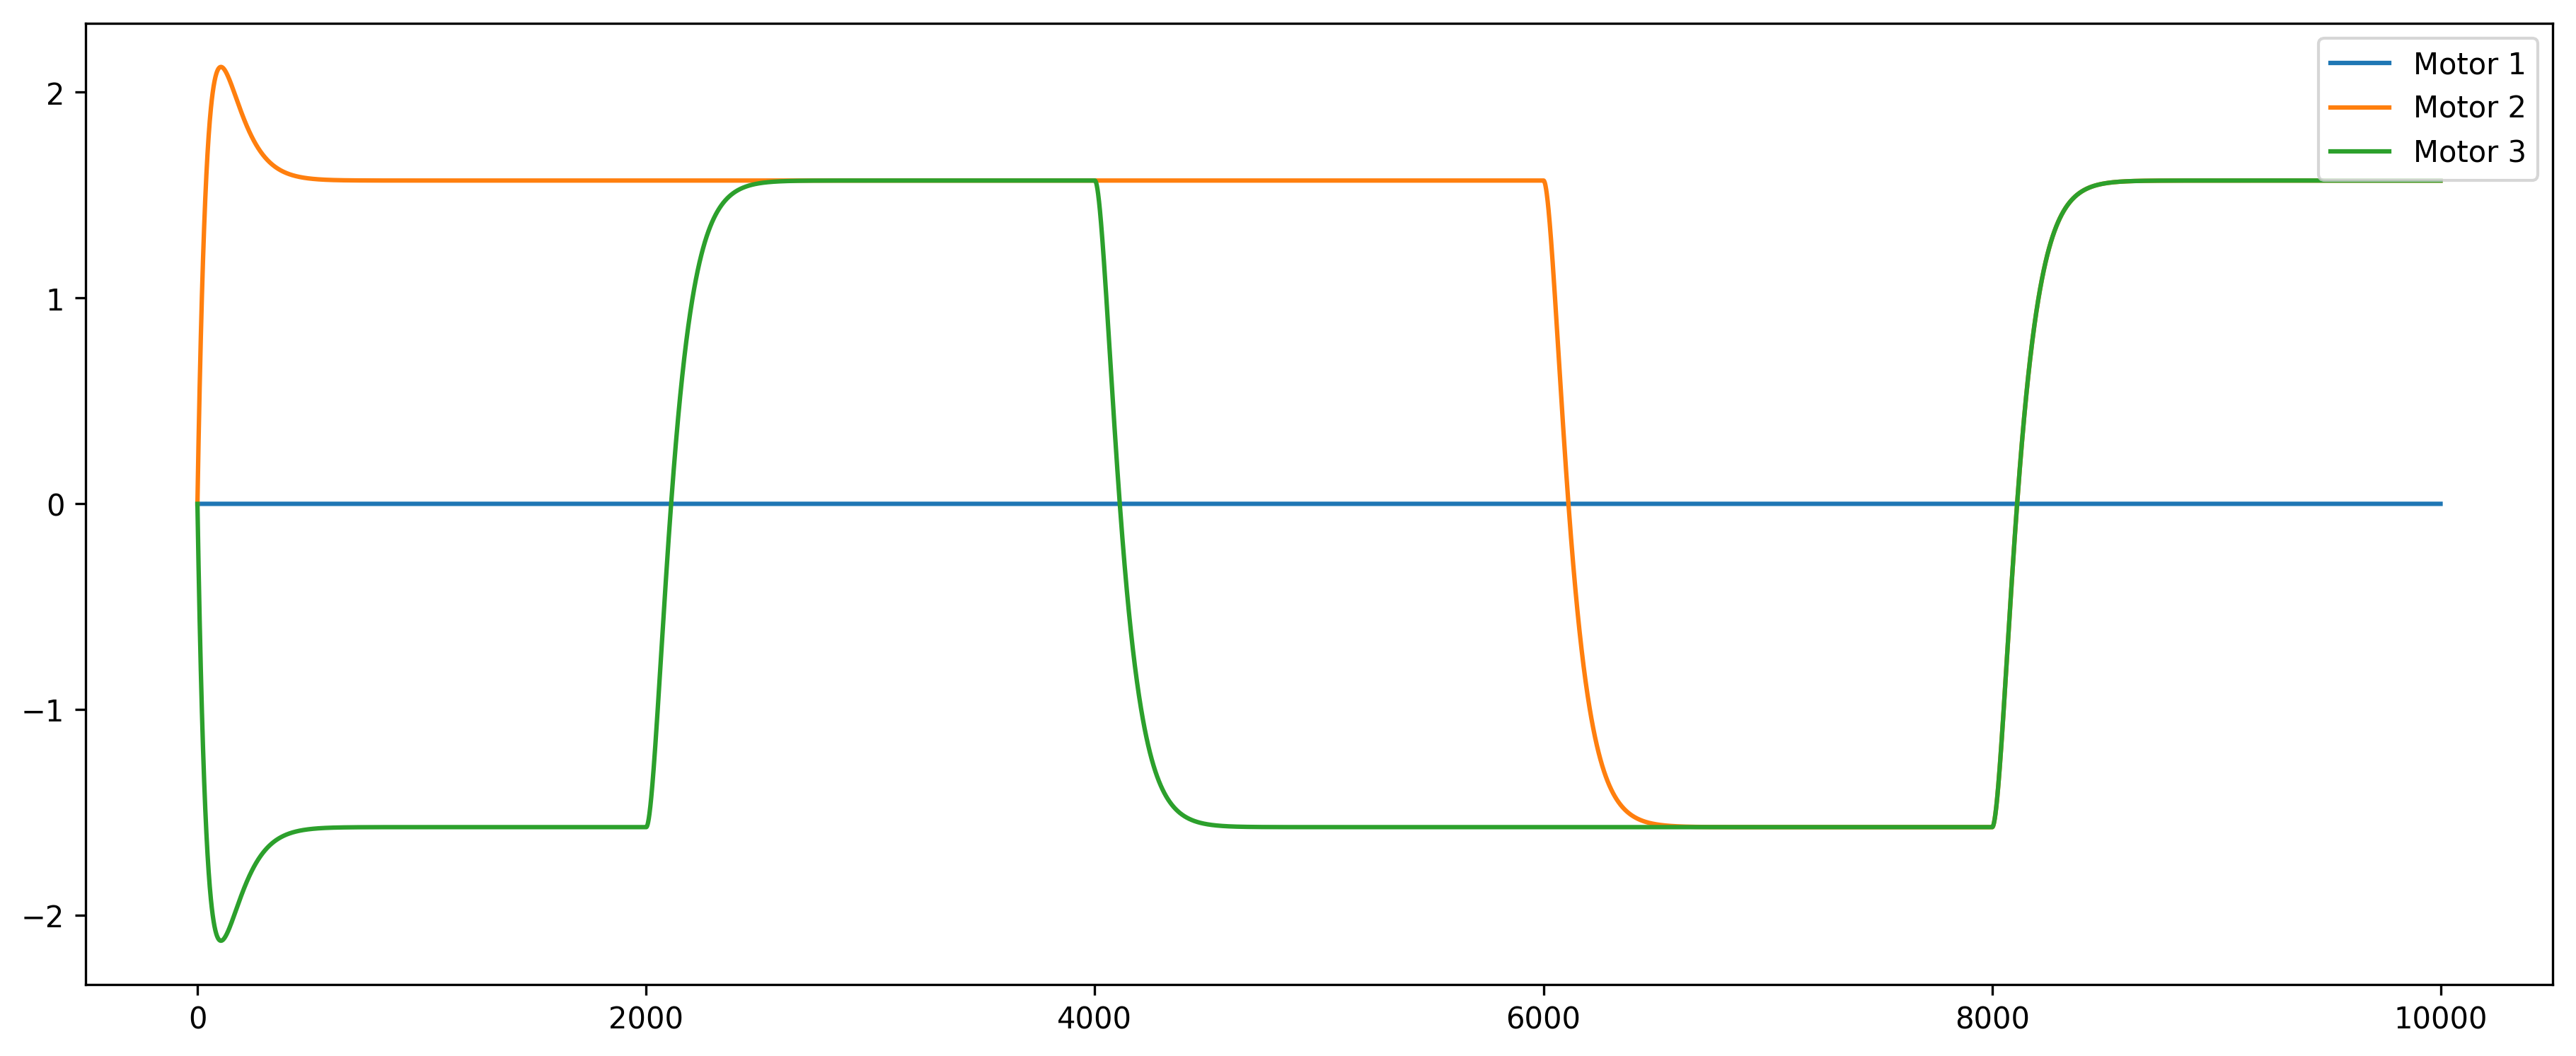

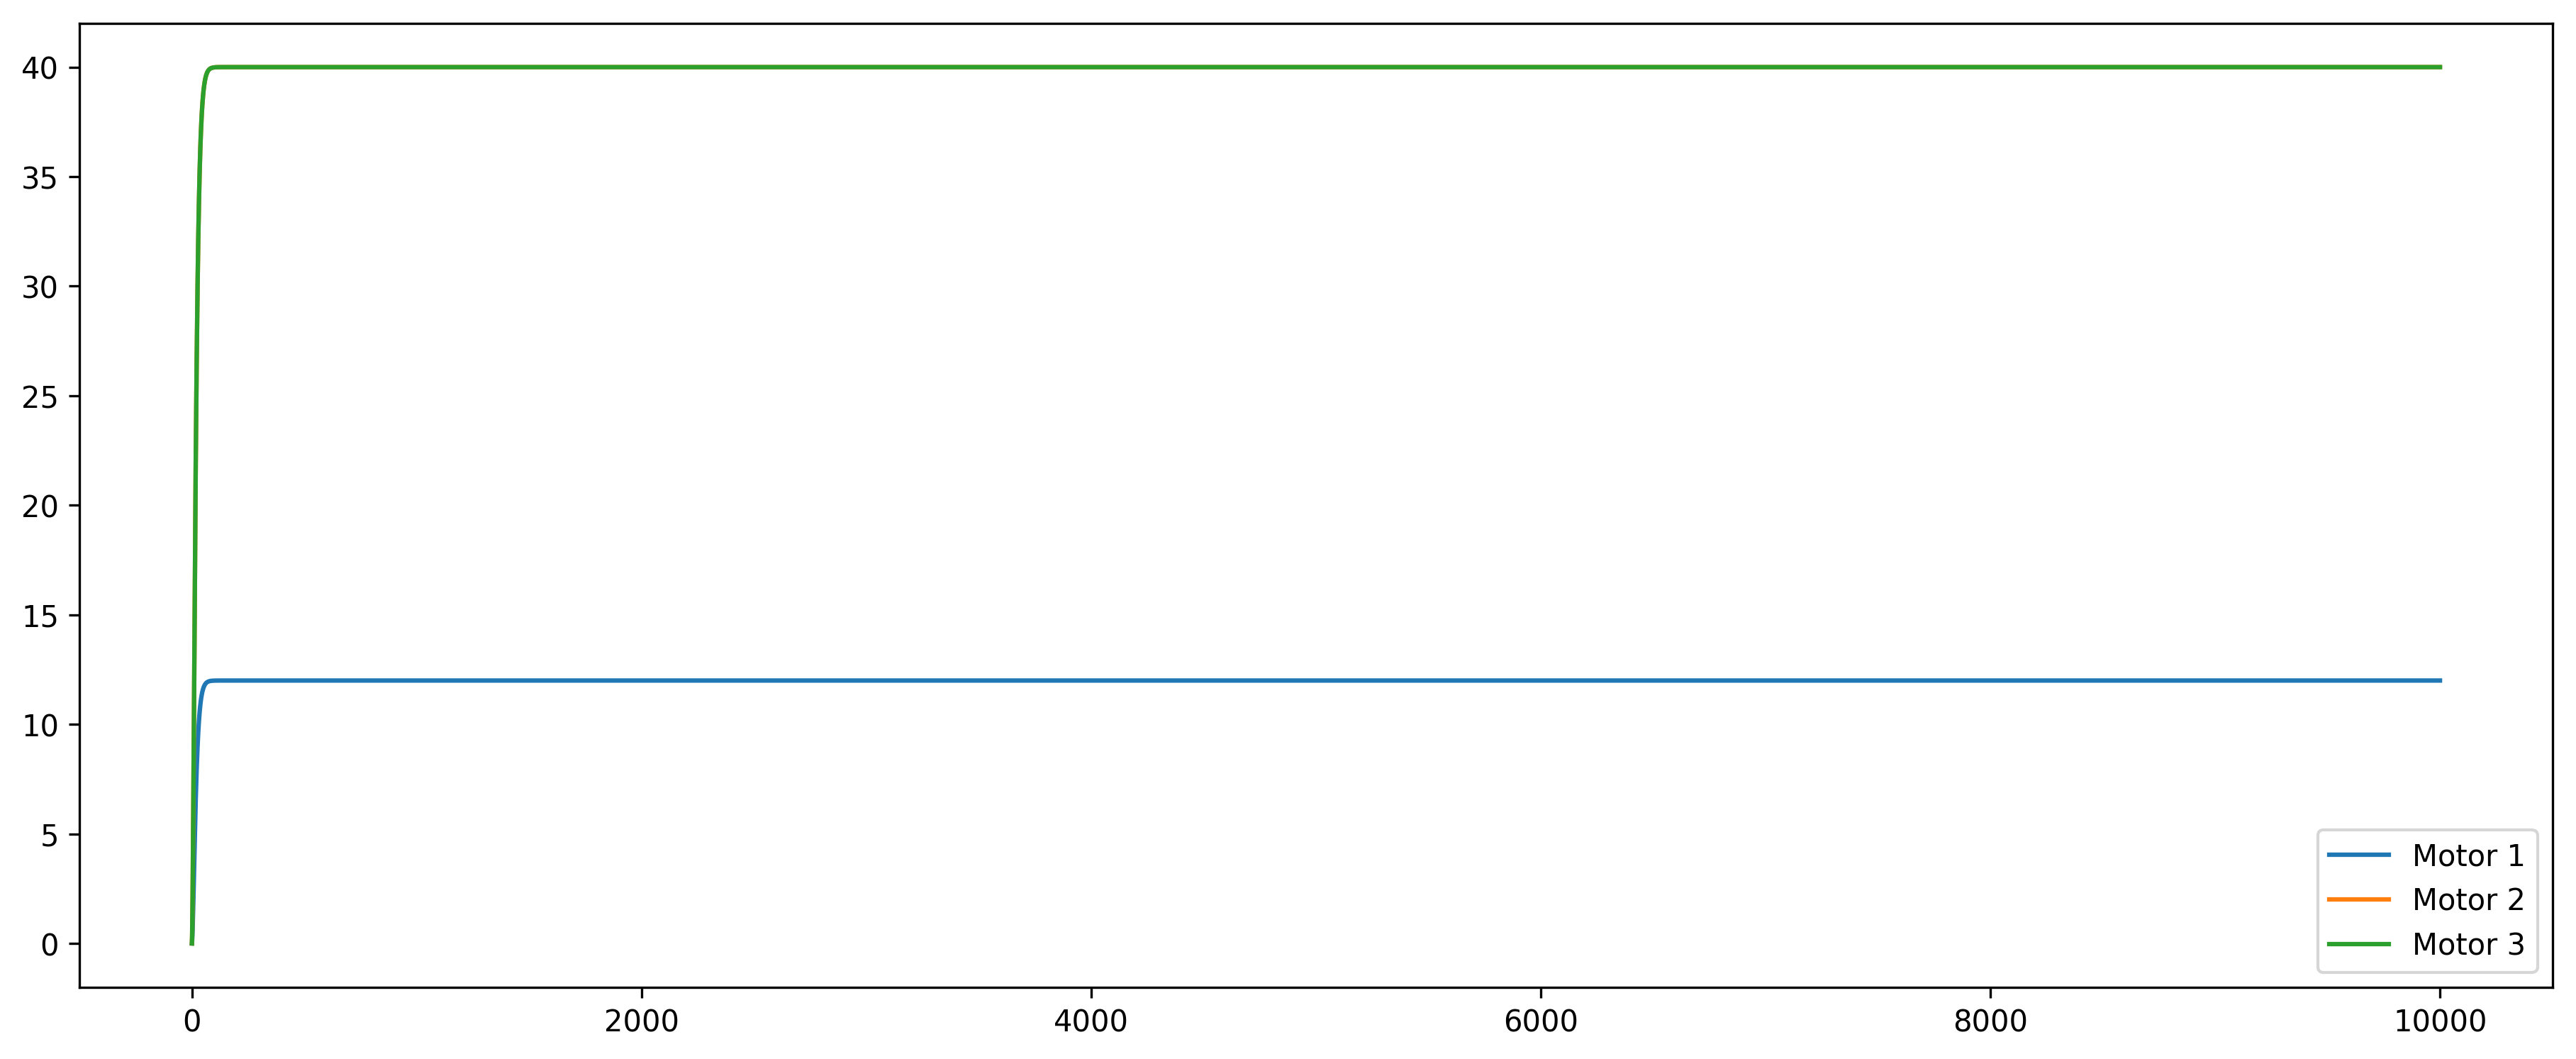

In [135]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt_m1, = plt.plot(theta[:2000,0], label='Motor 1')
plt_m2, = plt.plot(theta[:2000,1], label="Motor 2")
plt_m3, = plt.plot(theta[:2000,2], label="Motor 3")

colors = ['red', 'red', 'green', 'blue','magenta']
# plt.axvspan(0, gait_o[0][0]/h, color=colors[0], alpha=0.1)
# plt.text( (gait_o[0][0]/h - 0)/2, 45, gait_o[0][2] , fontsize=15, horizontalalignment='center')
for idx, gait in enumerate(gait_o[1:4]):
    plt.axvspan(gait_o[idx][0]/h, gait_o[idx+1][0]/h, color=colors[idx+1], alpha=0.1)
    plt.text((gait_o[idx+1][0] + gait_o[idx][0])/h/2 , 45, gait_o[idx][2],
             fontsize=15, horizontalalignment='center')
    break
# plt.axvspan(gait_o[-1][0]/h, sim_time/h, color='brown', alpha=0.1)
# plt.text( (sim_time/h + gait_o[-1][0]/h)/2, 45, gait_o[-1][2] , fontsize=15, horizontalalignment='center')
plt.legend(handles=[plt_m1, plt_m2, plt_m3])
plt.ylabel('motor position in degree')
plt.xlabel('time in 10ms steps')


plt.figure(num=None, figsize=(15, 6), dpi=300, facecolor='w', edgecolor='k')
plt_m1, = plt.plot(Phi_plot[:,0], label='Motor 1')
plt_m2, = plt.plot(Phi_plot[:,1], label="Motor 2")
plt_m3, = plt.plot(Phi_plot[:,2], label="Motor 3")
plt.legend(handles=[plt_m1, plt_m2, plt_m3])

plt.figure(num=None, figsize=(15, 6), dpi=300, facecolor='w', edgecolor='k')
plt_mx1, = plt.plot(x_plot[:,0], label='Motor 1')
plt_mx2, = plt.plot(x_plot[:,1], label="Motor 2")
plt_mx3, = plt.plot(x_plot[:,2], label="Motor 3")
plt.legend(handles=[plt_mx1, plt_mx2, plt_mx3])

plt.figure(num=None, figsize=(15, 6), dpi=300, facecolor='w', edgecolor='k')
plt_mr1, = plt.plot(r_plot[:,0], label='Motor 1')
plt_mr2, = plt.plot(r_plot[:,1], label="Motor 2")
plt_mr3, = plt.plot(r_plot[:,2], label="Motor 3")
plt.legend(handles=[plt_mr1, plt_mr2, plt_mr3])



# 